In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.signal import find_peaks

print("Setup Complete")

Setup Complete


In [2]:
# Read the samples and convert to array
mimic_afib_ppg_filepath = "../data/mimic_afib_data_100hz.csv"

with open(mimic_afib_ppg_filepath, 'r') as file:
    sample = sum(1 for _ in file)
    
mimic_afib_ppg_data = pd.read_csv(mimic_afib_ppg_filepath, nrows = sample)

signal = np.asarray(mimic_afib_ppg_data, dtype = np.float64)

print(signal)

[[0.53769036]
 [0.52824193]
 [0.52747131]
 ...
 [0.40423252]
 [0.4149324 ]
 [0.41805759]]


In [3]:
# Enhance signal

print(signal)

for i in range(len(signal)):
  signal[i] *= signal[i]

print(signal)

[[0.53769036]
 [0.52824193]
 [0.52747131]
 ...
 [0.40423252]
 [0.4149324 ]
 [0.41805759]]
[[0.28911092]
 [0.27903954]
 [0.27822598]
 ...
 [0.16340393]
 [0.17216889]
 [0.17477215]]


In [4]:
# Choose the Windows Size W1, W2 in TERMA framework
w_cycle =  55  # W2
w_evt = 9  # W1

ma_cycle = np.zeros_like(signal, dtype = np.float64)
ma_evt = np.zeros_like(signal, dtype = np.float64)

mean_signal = 0

# Calculate the Event Duration Moving Average
for i in range((w_evt - 1) // 2, len(signal) - ((w_evt - 1) // 2)):
    for j in range(-(w_evt - 1) // 2, (w_evt - 1) // 2):
        ma_evt[i] += signal[i + j]
    ma_evt[i] /= w_evt

# Calculate the Event Cycle Moving Average
for i in range((w_cycle - 1) // 2, len(signal) - ((w_cycle - 1) // 2)):
    for j in range(-(w_cycle - 1) // 2, (w_cycle - 1) // 2):
        ma_cycle[i] += signal[i + j]
    ma_cycle[i] /= w_cycle

# Calculate the mean of signal
for i in range(len(signal)):
    mean_signal += signal[i]
mean_signal /= len(signal)
mean = np.full(len(signal), mean_signal)

In [5]:
# Calculate the Threshold for detect Block of Interest
beta = 0.095
alpha = np.zeros_like(signal, dtype = np.float64)
threshold_1 = np.zeros_like(signal, dtype = np.float64)
block_of_interest = np.zeros_like(signal, dtype = np.float64)

for i in range(len(signal)):
  threshold_1[i] = ma_cycle[i] + beta * mean[i]

print(threshold_1)

# Generate the Block of Interest
for i in range(len(signal)):
  if (ma_evt[i] > threshold_1[i]) and (ma_cycle[i] != 0):
    block_of_interest[i] = 0.6
  else:
    block_of_interest[i] = 0

[[0.02349972]
 [0.02349972]
 [0.02349972]
 ...
 [0.02349972]
 [0.02349972]
 [0.02349972]]


In [6]:
# Peak detector
start_block = 0
stop_block = 0
peak = 0
peak_index = 0
peak_index_arr = np.zeros_like(signal, dtype = np.float64)
peak_arr = np.zeros_like(signal, dtype = np.float64)
block_num = 0

for i in range(len(block_of_interest) - 1):
  if (block_of_interest[i + 1] - block_of_interest[i]) == 0.6:
    start_block = i
  if (block_of_interest[i] - block_of_interest[i + 1]) == 0.6:
    stop_block = i
    if (stop_block - start_block) >= w_evt:
      peak = signal[start_block]
      for i in range(start_block, stop_block + 1):
        if signal[i] > peak:
          peak = signal[i]
          peak_index = i
      peak_arr[block_num] = peak
      peak_index_arr[block_num] = peak_index
      block_num += 1

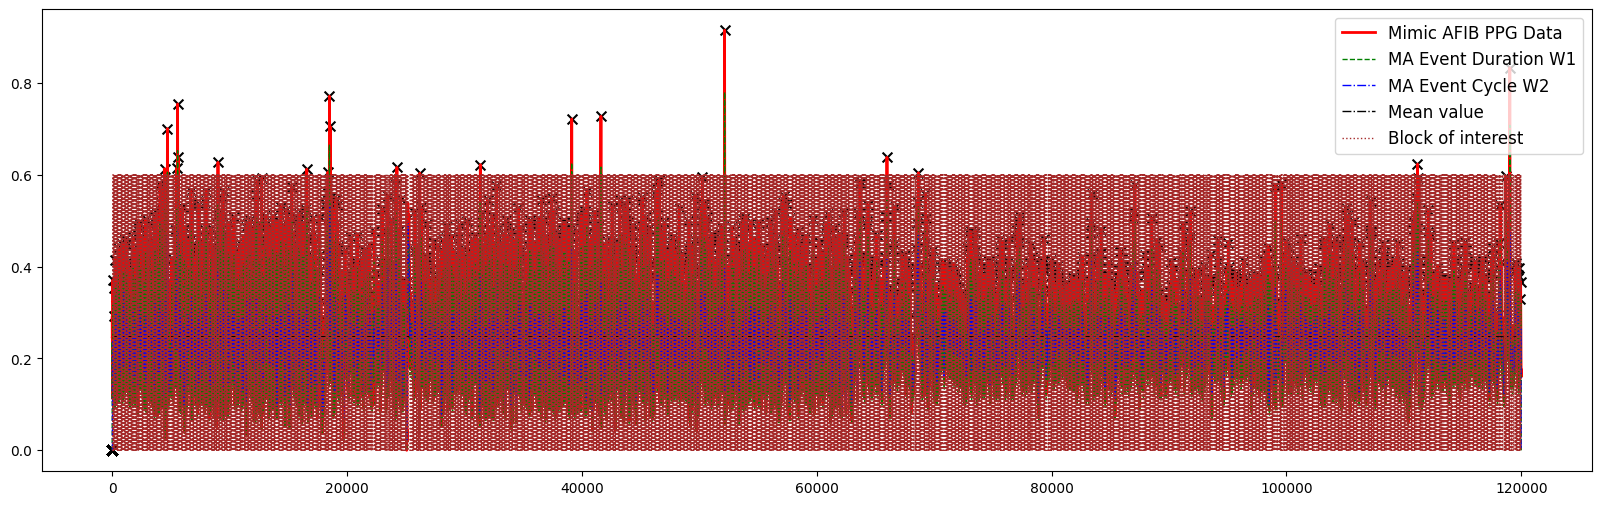

In [7]:
plt.figure(figsize = (20, 6))

x = np.arange(len(signal))

plt.plot(x, signal, linewidth = 2, color = 'red', label = 'Mimic AFIB PPG Data')
plt.plot(x, ma_evt, linewidth = 1, color = 'green', linestyle = '--', label = 'MA Event Duration W1')
plt.plot(x, ma_cycle, linewidth = 1, color = 'blue', linestyle = '-.', label = 'MA Event Cycle W2')
plt.plot(x, mean, linewidth = 1, color = 'black', linestyle = '-.', label = 'Mean value')
plt.plot(x, block_of_interest, linewidth = 1, color = 'brown', linestyle = ':', label = 'Block of interest')


plt.scatter(peak_index_arr, peak_arr, s = 50, marker = 'x', c = 'black')
plt.legend(loc = 'upper right', bbox_to_anchor = (1, 1), fontsize = 12)

plt.show()

In [8]:
# Read labeled peaks

peak_indices = pd.read_csv("labeled_peaks.csv", header = None).iloc[:, 0].values

In [9]:
fs = 100

peak_index_arr = peak_index_arr[:block_num]

tolerance = int(0.075 * fs)  # +-0.075 x fs

tp = 0
used_detected = set()
used_labeled = set()
fp_list = []
fn_list = []

for labeled_peak in peak_indices:
    for detected_peak in peak_index_arr:
        detected_peak_value = detected_peak.item()
        if (
            detected_peak_value not in used_detected
            and abs(detected_peak_value - labeled_peak) <= tolerance
        ):
            tp += 1
            used_detected.add(detected_peak_value)
            used_labeled.add(labeled_peak.item())
            break

fp_list = [
    peak.item() for peak in peak_index_arr if peak.item() not in used_detected
]
fp = len(fp_list)

fn_list = [
    peak.item() for peak in peak_indices if peak.item() not in used_labeled
]
fn = len(fn_list)

# Accuracy, Precision, Recall
accuracy = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
der = (fp + fn) / tp if tp > 0 else 0

print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Detection error rate: {der:.2f}")

confusion_matrix = np.array([[tp, fn], [fp, 0]])
print("Confusion Matrix:")
print(confusion_matrix)

print("\nFalse Positives (FP) at indices:", fp_list)
print("False Negatives (FN) at indices:", fn_list)


True Positives (TP): 1673
False Positives (FP): 15
False Negatives (FN): 109
Accuracy: 0.93
Precision: 0.99
Recall: 0.94
Detection error rate: 0.07
Confusion Matrix:
[[1673  109]
 [  15    0]]
